## Sort a list using a neural network

Input: A variable-length list of numbers $x_1, \dots, x_k$ with $x_i \in [0,1]$. 

Output: A sorted list of the same numbers.

We want to apply $\textbf{the same}$ network to any list independent of $k$.

General lists of any real numbers can be handled by rescaling to $[0,1]$

### Approach 

Treat the list as a fully connected directed graph where each node represents a number.
Use binary labels on the edges to encode a sorting path from the smallest to the largest number, i.e. the network should predict a starting node and the links to the next elements in a sorted linked list.

Note: Predicting the starting node is actually trivial. It is simply the smallest input number.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

We use a $n \times n$ matrix to indicate the successor for each of the $n$ nodes in the sorted list. The last node has no successor, i.e. it is represented by a 0-vector and will not contribute to the loss. We will also compute the indices that will bring the unsorted list into sorted form.

In [5]:
def make_example(min_max):
    num_elements = np.random.randint(min_max[0], min_max[1])
    values = np.random.rand(num_elements)
    sort_indices = np.argsort(values, axis=-1)
    smallest = np.eye(num_elements)[sort_indices[0]]
    links = np.zeros((num_elements, num_elements))
    links[sort_indices[:-1], sort_indices[1:]] = 1
    #links[sort_indices[-1], sort_indices[0]] = 1
    input_graph = {"nodes" : values}
    target_graph = {"start_node" : smallest,
                   "next_nodes" : links}
        
    return input_graph, target_graph, sort_indices

input_graph, target_graph, sort_indices = make_example((7,8))
print("numbers to sort:",input_graph)
print("next:",target_graph)
print("sort indices:",sort_indices)

numbers to sort: {'nodes': array([0.39822772, 0.3048047 , 0.16254316, 0.2667158 , 0.43061536,
       0.17363622, 0.32851825])}
next: {'start_node': array([0., 0., 1., 0., 0., 0., 0.]), 'next_nodes': array([[0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])}
sort indices: [2 5 3 1 6 0 4]


### Evaluation

We can evaluate the model by using a heatmap that highlights the successor for each node with $\textbf{sorted axis}$. A perfect prediction will look like below.

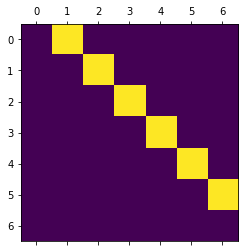

In [4]:
def plot_numbers(ax, next_nodes, sort_indices):
    ax.matshow(next_nodes[sort_indices][:, sort_indices], cmap="viridis")
    ax.grid(False)
    
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot()
plot_numbers(ax, target_graph["next_nodes"], sort_indices)

In [102]:
#intervals to sample lists lengths from
#we use short lists for training and longer lists for evaluation
NUM_NODES_TRAIN = (30,45)
NUM_NODES_VAL = (100,130)

class SampleGenerator(keras.utils.Sequence):

    def __init__(self, num_minmax, epoch_len):
        self.num_minmax = num_minmax
        self.epoch_len = epoch_len

    def __len__(self):
        return self.epoch_len #number of gradient descent steps per epoch

    def __getitem__(self, _index):
        inp, tar, _ = make_example(self.num_minmax)
        return inp, tar

Define a model. We use a very simple GNN with only node states. We only have node inputs which are the numbers to sort. For each node, we want to predict the probability of being the "start" node (i.e. the node with the smallest number). For each edge we want to predict whether it is a link in a sorted list. Edge predictions are done on pairs of node states. 

We don't use global attributes for in- and output.

In [103]:
#a feedforward layer
def make_ff_layer(config):
    return keras.Sequential([
            layers.Dense(config["latent_dim"], activation="relu"),
            layers.Dense(config["latent_dim"]),
            layers.LayerNormalization()])

def make_GNN(config):
    
    #define the inputs
    #note: keras inputs have their batch size omitted in "shape"
    V = keras.Input(shape=(1), name="nodes") 
    
    n = tf.shape(V)[0]
    
    #layers
    node_encoder = make_ff_layer(config)
    edge_encoder = layers.Dense(config["latent_dim"])
    node_messenger = make_ff_layer(config)
    edge_messenger = make_ff_layer(config)
    node_updater = make_ff_layer(config)
    edge_updater = make_ff_layer(config)
    node_decoder = layers.Dense(1)
    edge_decoder = keras.Sequential([
            layers.Dense(config["latent_dim"], activation="relu"),
            layers.Dense(1)])
    
    #step 1: encode
    #transform each node (dim=3) and edge (dim=1) to a latent embedding of "latent_dim"
    V_enc = node_encoder(V)
    E_enc = edge_encoder(tf.zeros((n,n,1)))
    
    start_node = []
    next_nodes = []
    
    #step 2: message passing
    for _ in range(config["message_passing_iterations"]):
        
        #the graph is fully connected, i.e. each node sends to all other nodes
        #we include self loops for simplicity
        E_message = edge_messenger(E_enc)
        E_message = tf.reduce_mean(E_message, axis=1)
        
        #update all nodes based on current state and aggregated edge states
        V_concat = tf.concat([V_enc, E_message], axis=-1)
        V_enc = node_updater(V_concat)
        
        #update all edges based on the current edge state and the 2 adjacent node 
        V_message = node_messenger(V_enc)
        V_tile = tf.tile(V_message, [n,1]) #abc -> (abc abc ... abc) 
        V_rep = tf.repeat(V_message, tf.ones(n,dtype=tf.int32)*n, axis=0) #abc -> (aa..a  bb..b  cc..c) 
        V_tile = tf.reshape(V_tile, (n,n,config["latent_dim"]))
        V_rep = tf.reshape(V_rep, (n,n,config["latent_dim"]))
        E_concat = tf.concat([E_enc, V_tile, V_rep], axis=-1)
        E_enc = edge_updater(E_concat)
        
        
        #decoding (after each iteration to evaluate performance over time)
        #for this GNN, we need node and edge predictions
        #for nodes, use the refined embeddings from message passing above:
        start_node_probs = node_decoder(V_enc)
        #remove "1" dimensions
        start_node_probs = tf.squeeze(start_node_probs)
        #decide for one start node
        start_node_probs = tf.nn.softmax(start_node_probs) 

        #for edges, use the respective pair of node embeddings (we did not use explicit edge embeddings)
        #organize edges as follows:
        #<n edges from v_1>, <n edges from v_2>, ..., <n edges from v_n>
        #we do not exclude self loops for simplicity
        next_node_probs = edge_decoder(E_enc)
        next_node_probs = tf.reshape(next_node_probs, (n,n))
        #for each node, decide for one "next" node
        next_node_probs = tf.nn.softmax(next_node_probs)
        
        start_node.append(start_node_probs)
        next_nodes.append(next_node_probs)
        
    outputs = []
    outputs.append(layers.Lambda(lambda x: x, name="start_node")(tf.stack(start_node)))
    outputs.append(layers.Lambda(lambda x: x, name="next_nodes")(tf.stack(next_nodes)))
    
    model = keras.Model(inputs=[V], 
                        outputs=outputs)

    return model    

In [105]:
config = {
    "message_passing_iterations" : 10,
    "latent_dim" : 16
}

NUM_EPOCHS = 20

train_gen = SampleGenerator(NUM_NODES_TRAIN, 2000)
val_gen = SampleGenerator(NUM_NODES_VAL, 50)

GNN = make_GNN(config)

cee = tf.keras.losses.CategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
acc_first_ = tf.keras.metrics.CategoricalAccuracy()
acc_next_ = tf.keras.metrics.CategoricalAccuracy()

def cee_last_iteration(y_true, y_pred):
    loss = 0
    for i in range(config["message_passing_iterations"]):
        loss += tf.reduce_mean(cee(y_true, y_pred[i])) #compute loss for all iterations
    return loss / config["message_passing_iterations"]
    #return tf.reduce_mean(cee(y_true, y_pred[-1]))

def acc_first(y_true, y_pred):
    return acc_first_(y_true, y_pred[-1])

def acc_next(y_true, y_pred):
    return acc_next_(y_true, y_pred[-1])

# The decay is useful for models with moderate accuracy where wrong predictions
# most likely are input numbers that are very similar.
# In this case, rather small updates of the weights are required.
lr_decay = tf.keras.optimizers.schedules.ExponentialDecay(1e-1, 1000, 0.7)

optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3)

GNN.compile(loss= {"start_node" : cee_last_iteration,
                "next_nodes" : cee_last_iteration}, 
            optimizer=optimizer, 
            metrics={"start_node" : acc_first,
                "next_nodes" : acc_next})

#takes ~2min on GPU
#note that this is unneccessarily long since we don't use batching
#to keep the code simple
history = GNN.fit(train_gen,
                    validation_data=val_gen,
                    epochs = NUM_EPOCHS,
                    verbose = 1)

Epoch 1/20
2000/2000 [==============================] - 71s 30ms/step - loss: 2.2234 - start_node_loss: 0.4881 - next_nodes_loss: 1.7353 - start_node_acc_first: 0.8186 - next_nodes_acc_next: 0.3115 - val_loss: 4.0965 - val_start_node_loss: 1.0087 - val_next_nodes_loss: 3.0878 - val_start_node_acc_first: 0.9205 - val_next_nodes_acc_next: 0.4874
Epoch 2/20
2000/2000 [==============================] - 58s 29ms/step - loss: 1.3138 - start_node_loss: 0.3671 - next_nodes_loss: 0.9467 - start_node_acc_first: 0.9444 - next_nodes_acc_next: 0.5453 - val_loss: 8.6792 - val_start_node_loss: 3.9763 - val_next_nodes_loss: 4.7029 - val_start_node_acc_first: 0.9497 - val_next_nodes_acc_next: 0.5998
Epoch 3/20
2000/2000 [==============================] - 58s 29ms/step - loss: 2.3565 - start_node_loss: 0.2940 - next_nodes_loss: 2.0625 - start_node_acc_first: 0.9593 - next_nodes_acc_next: 0.5146 - val_loss: 2.4314 - val_start_node_loss: 0.3499 - val_next_nodes_loss: 2.0815 - val_start_node_acc_first: 0.9

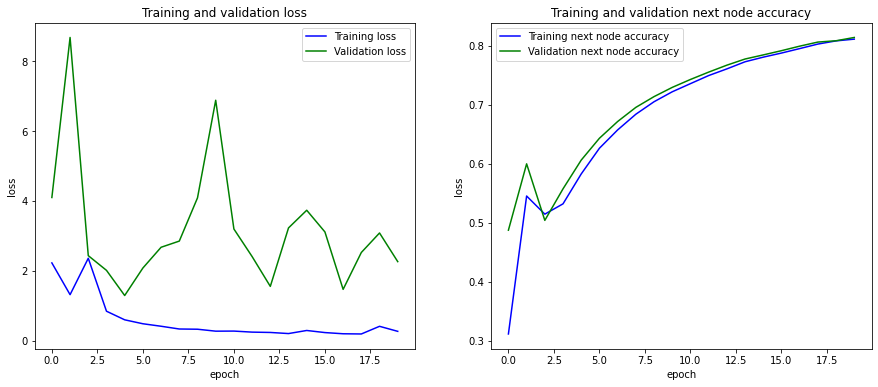

In [106]:
_, ax = plt.subplots(ncols = 2, figsize = (15, 6))

ax[0].plot(np.arange(NUM_EPOCHS), history.history["loss"], 'b', label = 'Training loss')
ax[0].plot(np.arange(NUM_EPOCHS), history.history["val_loss"], 'g', label = 'Validation loss')
ax[0].set_title('Training and validation loss')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend();

ax[1].plot(np.arange(NUM_EPOCHS), history.history["next_nodes_acc_next"], 'b', label = 'Training next node accuracy')
ax[1].plot(np.arange(NUM_EPOCHS), history.history["val_next_nodes_acc_next"], 'g', label = 'Validation next node accuracy')
ax[1].set_title('Training and validation next node accuracy')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend();

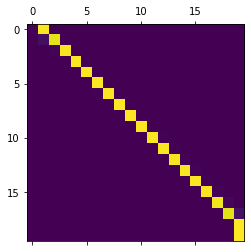

In [110]:
input_graph, _, sort_indices = make_example((20,21))
fig = plt.figure(1, figsize=(4, 4))
ax = fig.add_subplot()
start_node, next_nodes = GNN(input_graph)
start_node_probs = start_node[-1]
next_node_probs = next_nodes[-1]
plot_numbers(ax, next_node_probs.numpy(), sort_indices)

### Decode a sorted list

Start at the predicted start node. Greedily follow to the next unvisited node with highest probabilty.

In [111]:
def decode_sorting(numbers, start_node_probs, next_node_probs):
    print("unsorted numbers:", numbers)
    start = np.argmax(start_node_probs)
    sort_indices = [start]
    unvisited = np.ones(len(numbers))
    unvisited[start] = 0
    current_node = start
    for i in range(len(numbers)-1):
        probs = unvisited * next_node_probs[current_node]
        current_node = np.argmax(probs)
        unvisited[current_node] = 0
        sort_indices.append(current_node)
    print("sorted numbers:", numbers[sort_indices])

decode_sorting(input_graph["nodes"], start_node_probs, next_node_probs)

unsorted numbers: [0.16938192 0.84461391 0.22616482 0.20411431 0.04578072 0.12274356
 0.52547717 0.15104782 0.3889463  0.55589132 0.89224774 0.66335873
 0.32246891 0.26554763 0.29059985 0.70834625 0.80582798 0.97910701
 0.90664    0.92138999]
sorted numbers: [0.04578072 0.12274356 0.15104782 0.16938192 0.20411431 0.22616482
 0.26554763 0.29059985 0.32246891 0.3889463  0.52547717 0.55589132
 0.66335873 0.70834625 0.80582798 0.84461391 0.89224774 0.90664
 0.92138999 0.97910701]


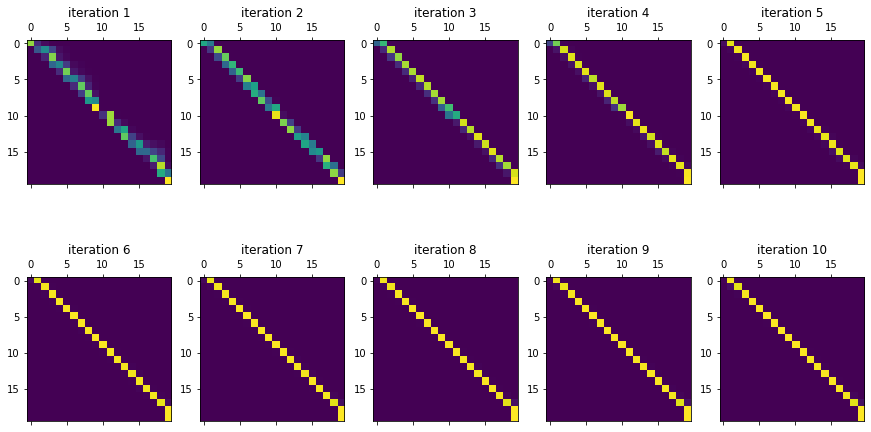

In [112]:
# sorting over time: A visualization of each iteration
ncols = 5
nrows = int(np.ceil(config["message_passing_iterations"]/ncols))

fig = plt.figure(1, figsize=(15, 8))
for i in range(config["message_passing_iterations"]):
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.set_title("iteration "+str(i+1))
    start_node_probs = start_node[i]
    next_node_probs = next_nodes[i]
    plot_numbers(ax, next_node_probs.numpy(), sort_indices)